# Python: A/B Testing with DoubleML

<img src="figures/ab_testing.jpg" alt="An illustration of A/B testing." style="width: 400px;"/>

Image Source Freepik http://www.freepik.com, Designed by macrovector


In this notebook, we illustrate how the [DoubleML](https://docs.doubleml.org/stable/index.html) package can be used to estimate the causal effect of seeing a new ad design on customers' purchases in a webshop. The [DoubleML](https://docs.doubleml.org/stable/index.html) package for Python and R provides an implementation of the double / debiased machine learning (DML) framework of [Chernozhukov et al. (2018)](https://arxiv.org/abs/1608.00060) and can be used to estimate causal effects based on machine learning (ML) methods.

## A/B Testing

A/B testing is a frequently used framework to perform causal inference in practice. For example, a manager of a webshop might be interested in optimally adapt the webshop design according to users' preferences. She might want to estimate the effect of a new ad design, which is displayed on the starting page, on a customer's purchases (in $100\$$). A/B tests refer to an experimental design in which a certain treatment, for example a new ad design (called "Version $A$"), that is randomly assigned to groups of individuals who are otherwise assigned to "Version $B$". The assignment can also be randomized among subgroups, i.e., randomly displayed to visitors once one or multiple of their characteristics are taken into consideration. For example, only visitors who have already purchased a product before might be exposed to the new ad. The goal is to conclude whether the treatment (= the new ad) has an effect on an outcome of interest (= monetary value of products purchased in $100\$$). Additional examples refer to improvement of a user experience on a website or estimation of price elasticities. Websites and apps are ideal for running A/B tests because they make it very easy to precisely direct the treatment to visitors and users (or to specific subgroups of them).

## Scenario

Let's consider the following stylized scenario. The manager of a webshop is performing A/B testing to estimate the effect of a new ad design $A$, on customers' purchases, $Y$. The treatment is assigned randomly conditional on the visitors' characteristics $V$. Such characteristics could be collected from a customer's shoppers account, for example. These might include the number of previous purchases, time since last purchase, length of stay on a page as well as whether a customer has a rewards card, among other characteristics. Let's assume the conditional randomization has been conducted properly, such that a tidy data set has been collected. Now, a data scientist wants to evaluate whether the new ad design causally affected the sales, by using the [DoubleML](https://docs.doubleml.org/stable/index.html) package.

### Why control for individual characteristics?

Before we start the case study, let us briefly address the question why we need to include individual characteristics in our analysis at all. There are mainly two reasons why we want to control for observable characteristics. First of all, so-called confounders, i.e., variables that have a causal effect on both the treatment variable and the outcome variable, possibly create a bias in our estimate. In order to uncover the true causal effect of the treatment, it is necessary that our causal framework takes all confounding variables into account. A second reason to include individual characteristics is efficiency. The more variation can be explained within our causal framework, the more precise will be the resulting estimate. In practical terms, greater efficiency leads to tighter confidence intervals and smaller standard errors and p-values.

### Why use machine learning to analyze A/B tests?

ML methods have turned out to be very flexible in terms of modeling complex relationships of explanatory variables and dependent variables and, thus, have exhibited a great predictive performance in many applications. In the double machine learning approach ([Chernozhukov et al. (2018)](https://arxiv.org/abs/1608.00060)), ML methods are used for modelling so-called nuisance parts. In terms of the A/B case study considered here, ML tools can be used to flexibly control for confounding variables. For example, a linear parametric specification as in a standard linear regression model might not be correct and, hence, not sufficient to address the underlying confounding. Moreover, by using powerful ML techniques, the causal model will likely be able to explain a greater share of the total variation and, hence, lead to more precise estimation.

## Data 

As an illustrative example we use a data set from the [ACIC 2019 Data Challenge](https://sites.google.com/view/acic2019datachallenge/data-challenge). In this challenge, a great number of data sets have been generated in a way that they mimic distributional relationships that are found in many economic real data applications. Although the data have not been generated explicitly to address an A/B testing case study, they are well-suited for demonstration purposes. We will focus on one of the many different data genereting processes (DGP) that we picked at random, in this particualar case a data set called `high42`. An advantage of using the [ACIC 2019 data](https://sites.google.com/view/acic2019datachallenge/data-challenge) is that we know the true average treatment effect which is 0.8 in our data set.

First we load the data.

In [1]:
import pandas as pd

#fetch_ACIChigh42 needs to be defined
#df = fetch_ACIChigh42(return_type='DataFrame')

#load code locally
df = pd.read_csv('data/high42.csv', sep=',', na_values=".")

#code can also be loaded using a URL of the data
#url = 'https://raw.githubusercontent.com/DoubleML/doubleml-hiwi-sandbox/master/case_studies/AB_testing/data/high42.CSV?token=AQWGKQRE57BBRGOCBPSNBJTBD57ZQ'
#df = pd.read_csv(url)

We see that the data set consists of 1000 observations (= website visitors) and 202 variables. The $Y$ column represents the number of page visits. The treatment variable $A$ is binary with a value 1 indicating that a customer has been exposed to the new ad design (and value 0 otherwise). The remaining 200 columns $V$ represent individual characteristics of the customers.

In [2]:
print(df.shape)

(1000, 202)


In [3]:
df.head()

,Y,A,V1,V2,V3,V4,V5,V6,V7,V8,...,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200
0,7.358185,1,10,0,0,7,192.793769,23.676950,8,0.185443,...,1.462837,1,1627.274196,0,0,4.683956,0.565667,0,3,0.024338
1,8.333672,1,12,0,1,4,199.653596,19.281270,7,0.514842,...,1.330522,1,1661.484439,1,0,6.766661,-0.395402,0,4,0.056518
2,7.472758,0,14,1,1,2,194.207792,24.589331,5,0.309199,...,1.384151,1,1658.939293,0,0,5.647794,1.112766,0,0,0.013442
3,6.502319,1,0,1,0,9,201.838024,25.513918,4,0.160160,...,1.220303,1,1650.801625,0,0,5.370363,-0.305842,0,4,0.034632
4,7.043758,1,12,0,0,9,201.360443,31.160641,6,0.291976,...,1.170094,1,1676.818876,0,0,3.446532,2.440661,0,1,0.017514


### Descriptive Statistics


Once we loaded the data, we find that the outcome variable, $Y$, is continuous with mean around $3.44$. The treatment variable $A$ is binary with a value of $1$ indicating that a visitor was exposed to the new ad design $A$ as opposed to design $B$ (corresponding to a value of $A$ equal to $1$). The control variables $V$ are a collection of mixed data types, including continuous, discrete and binary variables.

In [4]:
df.describe()

,Y,A,V1,V2,V3,V4,V5,V6,V7,V8,...,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000
mean,7.331239,0.443000,9.290000,0.377000,0.616000,6.477000,200.088758,28.066028,6.031000,0.294206,...,1.318209,0.94200,1667.454561,0.254000,0.174000,5.804205,-0.076921,0.29400,1.629000,0.037936
std,1.379852,0.496989,3.889605,0.484877,0.486601,2.870141,6.105408,9.920941,2.480361,0.119454,...,0.270178,0.23386,44.191913,0.435515,0.379299,2.655835,1.002754,0.45582,1.388988,0.021688
min,3.435052,0.000000,0.000000,0.000000,0.000000,0.000000,183.123067,12.020630,0.000000,0.047160,...,0.668093,0.00000,1524.291675,0.000000,0.000000,1.097708,-3.644652,0.00000,0.000000,0.001478
25%,6.405583,0.000000,7.000000,0.000000,0.000000,5.000000,195.941569,21.206230,4.000000,0.204260,...,1.119369,1.00000,1637.699514,0.000000,0.000000,4.065465,-0.751355,0.00000,1.000000,0.021711
50%,7.335248,0.000000,10.000000,0.000000,1.000000,7.000000,199.876117,26.202582,6.000000,0.282867,...,1.293790,1.00000,1667.763480,0.000000,0.000000,5.236465,-0.091056,0.00000,1.000000,0.034009
75%,8.271881,1.000000,12.000000,1.000000,1.000000,8.000000,204.398067,33.071189,8.000000,0.374078,...,1.476828,1.00000,1695.972631,1.000000,0.000000,6.898240,0.594647,1.00000,2.000000,0.049100
max,13.197260,1.000000,20.000000,1.000000,1.000000,15.000000,220.584410,95.410020,14.000000,0.706249,...,2.448661,1.00000,1825.697096,1.000000,1.000000,38.427974,2.832673,1.00000,9.000000,0.139716


From the explanatory vriables $V1$ to $V200$, 107 variables are continuous, while 95 are integers. From the integer-variables 59 are binary variables. 

In [5]:
print(df.dtypes.value_counts())
sum((df.max(0) == 1) & (df.min(0) == 0))

float64    107
int64       95
dtype: int64


59

Let's continue with some visual inspection. First we set the graph settings for graphing.

In [6]:
import seaborn as sns
sns.set()
colors = sns.color_palette()

import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = 5., 3.75
sns.set(font_scale=1.5)
sns.set_style('whitegrid', {'axes.spines.top': False,
                            'axes.spines.bottom': False,
                            'axes.spines.left': False,
                            'axes.spines.right': False})

The first figure shows that 443 out of the 1000 customers have been exposed to the new ad design.

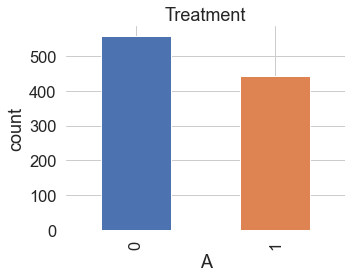

In [7]:
df['A'].value_counts().plot(kind='bar', color=colors)

plt.title('Treatment')
plt.xlabel('A')
_ = plt.ylabel('count')

### Unconditional Estimate of ATE

As a first naive estimate, we could calculate the unconditional average treatment effect (ATE). In other words, we simply take the difference between $Y$ observed for the customers who have been exposed to the treatment $(A=1)$ and those who haven't been exposed $(A=0)$. As a visualization, we plot the density of the outcome variable conditional on the treatment status to get a first impression on the descriptive relationship of $A$ and $Y$. One can see that customers-purchases Y is higher for the customers who saw the add, because the mean of the distribution $A=1$ is shifted to the right.

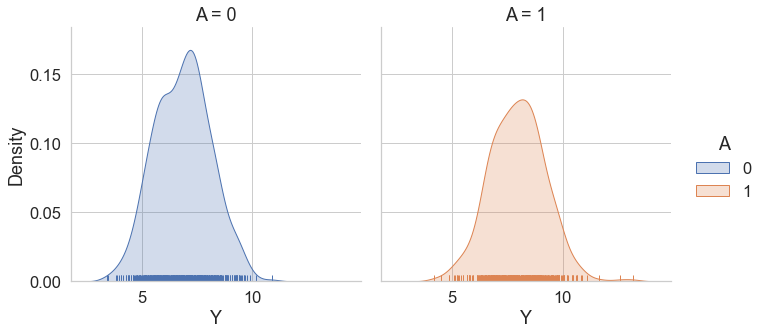

In [8]:
_ = sns.displot(df, x="Y", hue="A", col="A",
                kind="kde", rug = True, fill=True)

Since the unconditional ATE does not account for confounding variables, it will probably suffer from a severe bias. For example, there might be a subgroup of clients who regularly buy the a specific product from the webshop and directly jump on the website of this item. These customers will be less likely to see the ad but may have higher sales than other customers at the same time. By ignoring customers' browse history, we would probably underestimate the true causal effect. However, once we are able to observe the browse history, we would be able to adjust our estimation for this confounding factor.

In [9]:
df[['A', 'Y']].groupby('A').mean()

,Y
A,
0,6.836141
1,7.953744


In [10]:
df[['A', 'Y']].groupby('A').mean().diff()

,Y
A,
0,NaN
1,1.117603


The uncoditional effect is $1.117$. Because we use a simulated data set in this example, we know that the true effect is $0.8$. Therefore the unconditional effect overestimates the true effect, because it does not account for individual characteristics. In order to get an estimation on the ATE that explicitly takes the confounding variables $V$ into account, we apply the [DoubleML](https://docs.doubleml.org/stable/index.html) package in the next section.

## Estimate ATE with the `DoubleML` package

Let’s use the package [DoubleML](https://docs.doubleml.org/stable/index.html) to estimate the average treatment effect of the new ad design on the value of customers' purchases. First, the required packages are imported.

In [11]:
import numpy as np
import pandas as pd
import doubleml as dml

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

from sklearn.linear_model import LassoCV, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier, XGBRegressor

import matplotlib.pyplot as plt
import scipy.stats as stats

### The Data Backend: `DoubleMLData`

To start our analysis, we initialize the data backend from the previously loaded data set, i.e., we create a new instance of a [DoubleMLData](https://docs.doubleml.org/dev/api/generated/doubleml.DoubleMLData.html#doubleml.DoubleMLData) object. During initialization, we specify the roles of the variables in the data set, i.e., in our example the outcome variable $Y$ via the parameter `y_col`, the treatment variable $A$ via `d_cols` and the confounding variables $V$ via `x_cols`.

In [12]:
# Specify explanatory variables for data-backend
features_base = list(df.columns.values)[2:]

# Initialize DoubleMLData (data-backend of DoubleML)
data_dml = dml.DoubleMLData(df,
                            y_col='Y',
                            d_cols='A',
                            x_cols=features_base)

We can print the data-backend to see the variables, which we have assigned as outcome, treatment and controls.

In [13]:
print(data_dml)

================== DoubleMLData Object ==================

------------------ Data summary      ------------------
Outcome variable: Y
Treatment variable(s): ['A']
Covariates: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94', 'V95', 'V96', 'V97', 'V98', 'V99', 'V100', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108', 'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 'V115', 'V116', 'V1

## The Inference Problem and Choosing an Appropriate Model

The inference problem is to determine the causal effect of seeing the new ad design $A$ on a customer's purchases $Y$ once we control for individual characteristics $V$. In our example, we are interested in the average treatment effect. Basically, there are two causal models available in [DoubleMLData](https://docs.doubleml.org/dev/api/generated/doubleml.DoubleMLData.html#doubleml.DoubleMLData) that can be used to estimate the ATE.

The so-called interactive regression model (IRM) called by [DoubleMLIRM](https://docs.doubleml.org/dev/api/generated/doubleml.DoubleMLIRM.html) is a flexible model to estimate this causal quantity. The model does not impose functional form restrictions on the underlying regression relationships, for example, linearity or additivity as in a standard linear regression model. This means that the model hosts heterogeneous treatment effects, i.e., account for variation in the effect of the new ad design across customers. Moreover, it is possible to also estimate other causal parameters with the IRM, for example, the average treatment effect on the treated, which might be of interest too.

The second causal model that can be used here is the partially linear regression model (PLR). The PLR incorporates stronger assumptions, for example, that the treatment effect is additive and linear which implies that it does not vary across individuals. We will start with the IRM and include the PLR estimates at the end of the notebook.

## 1. Interactive Regression Model (IRM)

We briefly introduce the Interactive regression model (IRM) where the main regression relationship of interest is provided by

$$Y = g_0(D, X) + U, \quad E(U | X, D) = 0,$$

where the treatment variable is binary, $D \in \lbrace 0,1 \rbrace$. We consider estimation of the average treatment effects (ATE):

$$\theta_0 = \mathbb{E}[g_0(1, X) - g_0(0,X)],$$

when treatment effects are fully heterogeneous. In order to be able to use ML methods, the estimation framework generally requires a property called "double robustness" or "Neyman orthogonality". Double robustness can be achieved by including the first-stage estimation

$$D = m_0(X) + V, \quad E(V | X) = 0,$$

which amounts to estimation of the propensity score, i.e., estimation the probability that a customer is exposed to the treatment provided her observed characteristics.

Because data set was simulated we are aware of the true ATE, $\theta_0=0.8$. The interpretation of this is that exposure to the new ad increases sales (in $100\$$) by around $0.8$. In the following, we try to estimate this causal effect using the [DoubleML](https://docs.doubleml.org/stable/index.html) package and assess whether the estimated effect is significantly different from zero.

### Benchmark: Model based on Linear Regression

Let us first start with a benchmark model that is based on linear regression. Hence, we estimate the functions $g_0(D,X)$ using a linear regrssion model and $m_0(X)$ by using an (unpenalized) logistic regression. In both cases, we include all available characteristics $V$. Later we will assess whether we can find a "better" estimator based on ML methods like lasso, random forests and boosting. Because we have 200 variables and 1000 observations, this is approaching a high dimentional setting, therefore the linear regression may not estimate the parameters well.

We start by initializing the learners for linear regression and logistic regression. Then, we initialize a causal model object, here of the class [DoubleMLIRM](https://docs.doubleml.org/dev/api/generated/doubleml.DoubleMLIRM.html). The latter is based on the data-backend we have specified above. To reduce the disproportionate impact of extreme propensity score weights in the interactive model we trim the propensity score from below and above at thresholds of 0.025 and 0.975.

In [14]:
# Initialize learners
linreg = make_pipeline(StandardScaler(), LinearRegression())
logreg_class = make_pipeline(StandardScaler(),LogisticRegression(penalty="none"))

np.random.seed(123)
dml_irm_regression = dml.DoubleMLIRM(data_dml,
                                ml_g = linreg,
                                ml_m = logreg_class,
                                trimming_threshold = 0.025,
                                n_folds = 3,
                                    n_rep=3)

dml_irm_regression.fit(store_predictions=True)
reg_summary = dml_irm_regression.summary

reg_summary

,coef,std err,t,P>|t|,2.5 %,97.5 %
A,1.482385,0.660231,2.245252,0.024752,0.188356,2.776415


In [15]:
print("Bias:", dml_irm_regression.coef - 0.8)

Bias: [0.68238525]


We see that the causal estimate suffers from a substantial bias and is quite noisy: The ATE is overestimated by around 0.68 and the standard error is around 0.66. The corresponding confidence intervals are relatively wide, although they do not cover the value of zero. Hence, we can conclude that the average treatment effect is significantly different from zero at the 5% significance level.

Next, let us find out if we are able to use ML methods to find estimators that have a lower bias and a smaller standard error than the benchmark.

### Double Machine Learning based on Lasso

We estimate the nuisance components $g_0$ and $m_0$ using lasso as provided by [scikit-learn](https://scikit-learn.org). We load the learner by initializing instances from the classes [LassoCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html) and [LogisticRegressionCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html). Here we specify that the lasso should use the value of $\lambda$ that minimizes the cross-validated mean squared error, which is based on 5-fold cross validation. We initialize the [DoubleMLIRM](https://docs.doubleml.org/dev/api/generated/doubleml.DoubleMLIRM.html) object and use the newly defined learners.

In [16]:
# initialize Lasso learners
lasso = make_pipeline(StandardScaler(), LassoCV(cv=5, max_iter=20000))      
lasso_class = make_pipeline(StandardScaler(),
                            LogisticRegressionCV(cv=5, penalty='l1', solver='liblinear',     
                                                 Cs = 4, max_iter=1000))      


# Initialize DoubleMLIRM model
np.random.seed(123)
dml_irm_lasso = dml.DoubleMLIRM(data_dml,
                          ml_g = lasso,
                          ml_m = lasso_class,
                          trimming_threshold = 0.025,                          
                            n_folds = 3)

dml_irm_lasso.fit(store_predictions=True) 
lasso_summary = dml_irm_lasso.summary

lasso_summary

,coef,std err,t,P>|t|,2.5 %,97.5 %
A,0.834278,0.070511,11.831954,2.668556e-32,0.69608,0.972476


In [17]:
print("Bias:", dml_irm_lasso.coef - 0.8)

Bias: [0.03427819]


We see that the lasso-based estimate for the ATE is $0.83$ and, hence, much closer to the true value of $0.8$ than in the benchmark $1.48$. Moreover, we can achieve improvements in terms of estimation precision as can be recognized from the smaller standard error. 

### Double Machine Learning based on Random Forest

Alternatively, we can repeat this procedure with other machine learning methods, for example a random forest learner as provided by the [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) and [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) class in [scikit-learn](https://scikit-learn.org).

In [18]:
# Random Forest
randomForest = RandomForestRegressor()
randomForest_class = RandomForestClassifier()

np.random.seed(123)
dml_irm_forest = dml.DoubleMLIRM(data_dml,
                                 ml_g = randomForest,
                                 ml_m = randomForest_class,
                                 trimming_threshold = 0.025,
                                 n_folds = 3)

#Set nuisance-part specific parameters
dml_irm_forest.set_ml_nuisance_params('ml_g0', 'A', {
    'max_features': 200, 'n_estimators': 250})
dml_irm_forest.set_ml_nuisance_params('ml_g1', 'A', {
    'max_features': 200, 'n_estimators': 250})
dml_irm_forest.set_ml_nuisance_params('ml_m', 'A', {
    'max_features': 200, 'n_estimators': 250})

dml_irm_forest.fit(store_predictions=True) 
forest_summary = dml_irm_forest.summary

forest_summary

,coef,std err,t,P>|t|,2.5 %,97.5 %
A,0.86203,0.08229,10.475455,1.119983e-25,0.700743,1.023316


In [19]:
print("Bias:", dml_irm_forest.coef - 0.8)

Bias: [0.0620296]


The results are relatively similar to the one obtained by lasso with a bias and standard errors that are slightly greater than before.

### Double Machine Learning based on Extreme Gradient Boosting

Next, we estimate the ATE using extreme gradient boosting as provided by [xgboost](https://docs.getml.com/latest/api_reference/predictors.html).

In [20]:
boost = XGBRegressor(n_jobs=1, objective = "reg:squarederror")
boost_class = XGBClassifier(use_label_encoder=False, n_jobs=1,
                            objective = "binary:logistic", eval_metric = "logloss")

np.random.seed(123)
dml_irm_boost = dml.DoubleMLIRM(data_dml,
                                ml_g = boost,
                                ml_m = boost_class,
                                trimming_threshold = 0.025,
                                n_folds = 3)

#Set nuisance-part specific parameters
dml_irm_boost.set_ml_nuisance_params('ml_g0', 'A', {
    'n_estimators': 30, 'eta': 0.2})
dml_irm_boost.set_ml_nuisance_params('ml_g1', 'A', {
    'n_estimators': 30, 'eta': 0.2})
dml_irm_boost.set_ml_nuisance_params('ml_m', 'A', {
    'n_estimators': 15, 'eta': 0.2})

dml_irm_boost.fit(store_predictions=True)
boost_summary = dml_irm_boost.summary
boost_summary

,coef,std err,t,P>|t|,2.5 %,97.5 %
A,0.739225,0.092511,7.990648,1.342310e-15,0.557906,0.920544


In [21]:
print("Bias:", dml_irm_boost.coef - 0.8)

Bias: [-0.06077519]


The estimated coefficient is close to the true ATE of $0.8$ but has a small negative bias. The interpretation of the results obtained with lasso, random forests and boosting are very similar. In all cases we are able to reject the null hypothesis that the ad has no effect on the sales.

### Summary of IRM Results

We define a small function which calculates the bias from the true parameter $0.8$. Then we save the estimates, bias and confidence intervals for peresentation and comparision.

In [22]:
def bias(x):
    x=x - 0.8
    x=round(abs(x),3)
    return x

irm_summary = pd.concat((reg_summary, lasso_summary, forest_summary, boost_summary))
irm_summary.index = ['regression','lasso', 'forest', 'xgboost']
irm_summary=irm_summary[['coef', '2.5 %', '97.5 %']]
irm_summary.insert(1, "Bias", [bias(irm_summary.loc['regression','coef']), 
                               bias(irm_summary.loc['lasso','coef']), 
                               bias(irm_summary.loc['forest','coef']), 
                               bias(irm_summary.loc['xgboost','coef'])])
irm_summary.round(3)

,coef,Bias,2.5 %,97.5 %
regression,1.482,0.682,0.188,2.776
lasso,0.834,0.034,0.696,0.972
forest,0.862,0.062,0.701,1.023
xgboost,0.739,0.061,0.558,0.921


### Conclusion

We conclude that the interactive regression model (IRM) estimates are close to the true coefficient value, if the nuisance components are estimated with machine learning methods. The best results in terms of the smallest bias and standard errors is achieved by the lasso-based DML estimator for the ATE. The performance of the tree-based methods: random forests and extreme gradient boosting are comparable. All of the ML-based estimators have exhibited a superior performance to the benchmark based on linear and logistic regression.


## 2. Partially Linear Regression Model (PLR)

The [DoubleML](https://docs.doubleml.org/stable/index.html) package also includes the partial linear regression (PLR) Model, which assumes the data have an additive structure. Although we don't know if this structure really holds for the underlying data generating process, we can apply this model and see how the estimates compare to those from the IRM.

We estimate the function $g_0$ and $m_0$ in the following PLR model:

\begin{eqnarray}
& Y = D\theta_0 + g_0(X) + \zeta, &\quad E[\zeta \mid D,X]= 0,\\
& D = m_0(X) +  V, &\quad E[V \mid X] = 0.
\end{eqnarray}

To estimate the causal parameter $\theta_0$ here, we use double machine learning with 3-fold cross-fitting. The steps of our analysis are very similar to the IRM cases with the difference being that we use a model class [DoubleMLPLR](https://docs.doubleml.org/dev/api/generated/doubleml.DoubleMLPLR.html) for estimation.

### Benchmark: Model based on Linear Regression

In [23]:
linreg = make_pipeline(StandardScaler(), LinearRegression())
logreg_class = make_pipeline(StandardScaler(),LogisticRegression(penalty="none"))

np.random.seed(123)
# Initialize DoubleMLPLR model
dml_plr_regression = dml.DoubleMLPLR(data_dml,
                                     ml_g = linreg,
                                     ml_m = logreg_class,
                                     n_folds = 3)

dml_plr_regression.fit(store_predictions=True)
reg_summary = dml_plr_regression.summary

reg_summary

,coef,std err,t,P>|t|,2.5 %,97.5 %
A,0.774071,0.070216,11.024117,2.923733e-28,0.63645,0.911692


### Double Machine Learning based on Lasso

In [24]:
np.random.seed(123)
# Initialize DoubleMLPLR model
dml_plr_lasso = dml.DoubleMLPLR(data_dml,
                                ml_g = lasso,
                                ml_m = lasso_class,
                                n_folds = 3)

dml_plr_lasso.fit(store_predictions=True)
lasso_summary=dml_plr_lasso.summary

lasso_summary

,coef,std err,t,P>|t|,2.5 %,97.5 %
A,0.784579,0.070414,11.142419,7.797228e-29,0.64657,0.922587


### Double Machine Learning based on Random Forests

In [25]:
randomForest = RandomForestRegressor()
randomForest_class = RandomForestClassifier()

np.random.seed(123)
dml_plr_forest = dml.DoubleMLPLR(data_dml,
                                 ml_g = randomForest,
                                 ml_m = randomForest_class,
                                 n_folds = 3,
                                n_rep = 3)

dml_plr_forest.fit(store_predictions=True)
forest_summary = dml_plr_forest.summary

forest_summary

,coef,std err,t,P>|t|,2.5 %,97.5 %
A,0.823899,0.073474,11.213529,3.499555e-29,0.679893,0.967904


### Double Machine Learning based on Extreme Gradient Boosting

In [26]:
boost = XGBRegressor(n_jobs = 1, objective = "reg:squarederror",                         #where did you get tuning params?    #grid search?
                     eta = 0.1, n_estimators = 57, max_depth = 2)
boost_class = XGBClassifier(use_label_encoder=False, n_jobs=1,
                            objective = "binary:logistic",
                            eval_metric = "logloss",
                            eta = 0.1, n_estimators = 10,
                            max_depth = 3)

np.random.seed(123)
dml_plr_boost = dml.DoubleMLPLR(data_dml,
                                ml_g = boost,
                                ml_m = boost_class,
                                n_folds = 3)
dml_plr_boost.fit()
boost_summary = dml_plr_boost.summary

boost_summary

,coef,std err,t,P>|t|,2.5 %,97.5 %
A,0.814555,0.071203,11.439929,2.641013e-30,0.675,0.95411


In [27]:
plr_summary = pd.concat((reg_summary, lasso_summary, forest_summary, boost_summary))
plr_summary.index = ['regression','lasso', 'forest', 'xgboost']
plr_summary=plr_summary[['coef', '2.5 %', '97.5 %']]
plr_summary.insert(1, "Bias", [bias(plr_summary.loc['regression','coef']), 
                               bias(plr_summary.loc['lasso','coef']), 
                               bias(plr_summary.loc['forest','coef']), 
                               bias(plr_summary.loc['xgboost','coef'])])
plr_summary.round(3) 

,coef,Bias,2.5 %,97.5 %
regression,0.774,0.026,0.636,0.912
lasso,0.785,0.015,0.647,0.923
forest,0.824,0.024,0.680,0.968
xgboost,0.815,0.015,0.675,0.954


### Summary of IRM and PLR Results

In [28]:
df_summary = pd.concat((irm_summary,plr_summary)).reset_index().rename(columns={'index': 'ML'})
df_summary['Model'] = np.concatenate((np.repeat('IRM', 4), np.repeat('PLR', 4)))
df_summary.set_index(['Model', 'ML']).round(3)

coef   Bias  2.5 %  97.5 %
Model ML                                     
IRM   regression  1.482  0.682  0.188   2.776
      lasso       0.834  0.034  0.696   0.972
      forest      0.862  0.062  0.701   1.023
      xgboost     0.739  0.061  0.558   0.921
PLR   regression  0.774  0.026  0.636   0.912
      lasso       0.785  0.015  0.647   0.923
      forest      0.824  0.024  0.680   0.968
      xgboost     0.815  0.015  0.675   0.954

### Conclusion

As in the IRM model, the ML-based PLR models are associated with a smaller bias as compared to the model that is based on linear regression. It seems that the estimates obtained from the PLR are slightly closer to the true ATE than those from the IRM analysis. This might suggest, that the parametric assumptions (i.e., an additive and homogeneous causal effect) that are incorporated in the PLR turn out to be **not restrictive** in our example data set. However, if both models are based on appropriate ML learners, the conclusions are very similar. In all cases, the ML-based estimates were very close to the true ATE and we were always able to reject the null hypothesis of a zero-effect at all common significance levels. In terms of the A/B testing example, it can be concluded that the new ad increases customers purchases (in $100\$$) by around 0.8 on average and that this effect is significantly different from zero at the 5% significance level. The results are summarized in the graphic below.

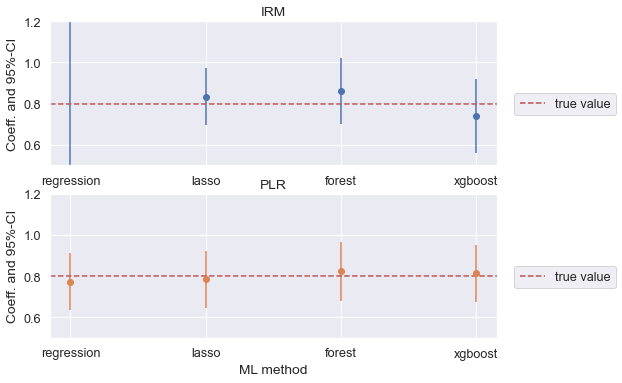

In [29]:
plt.figure(figsize=(8, 9))
colors = sns.color_palette()
for ind, model in enumerate(['IRM', 'PLR']):
    sns.set(font_scale=1.15)
    plt.subplot(3, 1, ind+1)
    this_df = df_summary.query('Model == @model')
    errors = np.full((2, this_df.shape[0]), np.nan)
    errors[0, :] = this_df['coef'] - this_df['2.5 %']
    errors[1, :] = this_df['97.5 %'] - this_df['coef']
    plt.errorbar(this_df.ML, this_df.coef, fmt='o', yerr=errors,
                 color=colors[ind], ecolor=colors[ind])
    plt.ylim([0.5, 1.2])
    plt.title(model)
    plt.ylabel('Coeff. and 95%-CI')
    plt.axhline(y=0.8, color='r', linestyle='--', label="true value")
    plt.legend(bbox_to_anchor=(1.04,0.5), loc="best", borderaxespad=0)

_ = plt.xlabel('ML method')


______

**Notes and Acknowledgement**

We would like to thank the organizers of the [ACIC 2019 Data Challenge](https://sites.google.com/view/acic2019datachallenge/data-challenge) for setting up this data challenge and the numerous synthetic data examples that are all available online. Although the data examples in the [ACIC 2019 Data Challenge](https://sites.google.com/view/acic2019datachallenge/data-challenge) do not explicitly adress A/B testing, we put the data example here in this context to give a tractable example on the use of causal machine learning in practice. The parameters for the random forests and extreme gradient boosting learners have been tuned externally. The corresponding tuning notebook will be uploaded in the examples gallery in the future.

## References

Chernozhukov, V., Chetverikov, D., Demirer, M., Duflo, E., Hansen, C., Newey, W. and Robins, J. (2018), Double/debiased machine learning for treatment and structural parameters. The Econometrics Journal, 21: C1-C68. doi:10.1111/ectj.12097.